In [1]:
from tokenize import PlainToken
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.multiprocessing as mp
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas as pd
import numpy as np
import time
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

from DeepMKVSolver import deepMKV
from NeuralNets import Network
from Parameters import GameConfig
import os
# Set multiprocessing start method
mp.set_start_method('spawn', force=True)

# Set default tensor type
d_type = torch.float32
torch.set_default_dtype(d_type)
import warnings
warnings.filterwarnings("ignore")


ImportError: cannot import name 'GameConfig' from 'Parameters' (/Users/xinyuli/Desktop/Code/McKeanVlasovSolver/Parameters.py)

In [2]:
from Path_MKV_Solver import PathMKV
# from DeepMKVSolver import deepMKV

In [3]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
N = 100 # num of time discretization intervals
d = 1# dimension of Xt

In [5]:
  
class PathModel():
    def __init__(self, params_equ, device, kappa=2, sigma=1, q=0.8, T=0.2, eta=2, c=2, \
        mu_0 = 0, sigma_0 = 1,
        BM_dim=None, u_dim=None) -> None:
        self.terminal = params_equ["T"]
        self.sigma_ = sigma
        self.kappa = kappa
        self.q = q
        self.eta = eta
        self.c = c



        self.d = params_equ["state_dim"] # dimension of Xt
        # dim of Brownian motion
        self.BM_dim = params_equ["BM_dim"]
        # dim of control 
        self.u_dim = params_equ["u_dim"]
        # number of samples
        self.M = params_equ["M"]
        self.device = device

        # default mean and covariance for the initial random variable
        self.mu0 = mu_0 * torch.tensor(np.ones(self.d)).float().to(device)
        self.var0 = sigma_0**2 * torch.tensor(np.eye(self.d)).float().to(device) 
    
    def change_mean_var(self, mu0, var0):
        """
        mu0: numpy array [d,]
        sigma0: numpy matrix [d * d]
        """
        self.mu0 = torch.tensor(mu0).float().to(self.device)
        self.var0 = torch.tensor(var0).float().to(self.device)


    
    def generate_initial_condition(self):
        # Shape: (M, d)
        L = torch.linalg.cholesky(self.var0)
        Gaussian_noise = torch.randn(self.M, self.d, device=self.device).float()
        x = self.mu0 + Gaussian_noise @ L.T 
        return x #x.view(self.d*self.M)

    
    def mu(self, t, Xt, control):
        """
        Xt: Batch size (M) * d  
        control: (M, d)

        return: (M,d)
        """
        #mu_t = self.get_mean_expanded(Xt)
        return self.kappa * Xt + control
        #return torch.sin(Xt)   + control 
        #return self.kappa * torch.log (1/torch.abs(Xt)) * control

    def sigma(self, t, Xt, control):
        return self.sigma_ * Xt
        
    
    def get_mean_expanded(self, Xt):
        """
        Xt: Batch size (M) * d  

        return: M copies of mu_t in shape of (M,d)
        """
        return torch.mean(Xt, axis=0).expand(self.M,-1) # (M,d)

    def get_empirical_prob(self, Xt):
        return  torch.mean(1.0*(Xt >= 0.05), axis=0).expand(self.M, -1)

    def f_running(self, t, X_path, control):
        return 0.01 * torch.mean(torch.bmm(control.unsqueeze(1), control.unsqueeze(2))) 
 
    def g_terminal(self, X_path):
        K = 1.25
        payoff =torch.abs(torch.mean(X_path, dim=1) - K)
        mean_payoff = torch.mean(payoff)
        var_payoff = torch.var(payoff)
        # print(mean_payoff, var_payoff)
        return  mean_payoff + var_payoff

In [6]:
T, kappa, q, c, eta = 1, 0.6, 0.8, 2, 2
sigma =1
mu_0 , sigma_0 =0, 0.5
device = "cpu"


In [7]:

control_type = ["path_dependent", "markovian"][0]
input_param = (N * (control_type == "path_dependent") + 2)*d
input_param


# ============================================================================
# Define all parameters 
# ============================================================================
params = {
    # Parameters of the game setup
    "equation": {
            "state_dim": d, "BM_dim": d, "u_dim": d, 
            "M": 500, # number of particles
            "N": N,# number of time intervals
            "T": T,
            "control_type": control_type
        },
    "train": {
        "lr_actor": 1e-3, "gamma_actor":0.8, "milestones_actor": [30000, 40000],
        "iteration": 50, "epochs": 50, "device": device,  
    },
    "net": {
        # Choose block type: "res" for ResNet block, "fc" for fully connected block
        "block_type": ["fc", "rnn"][1],
        "inputs": input_param, "output": d, 


        # RNN network parameters(only used when block_type="rnn")
        "width": 100, "depth": 4, #N + 10, "depth": 4, 
        "activation": "ReLU", "penalty": "Tanh",
        "params_act": {"Tanh": nn.Tanh(), "Tanhshrink": nn.Tanhshrink(), "ReLU": nn.ReLU(), "ReLU6": nn.ReLU6()},
        
        
        # Fully connected network parameters (only used when block_type="fc")
        "hidden_layers": [20, 20], #[N + 10, N + 10, N + 10],  #widths of hidden layers 
        "dropout_rate": 0.1,  # Add dropout for regularization
    },
}


# ============================================================================
# Create control networks
# ============================================================================
net_control = Network(params["net"]) 
setup = PathModel(params["equation"], device, kappa,sigma, q, T, eta, c, \
        mu_0 , sigma_0 )

In [220]:
N

100

In [9]:
self = PathMKV(net_control, setup, params)
t, W, DW = self.fetch_minibatch()

X0 = setup.generate_initial_condition()
X_buffer, loss = self.loss_function( net_control, t, DW, X0)


dt 0.01


In [10]:
self.control_type+ "_" +params["net"]["block_type"]

'path_dependent_rnn'

In [11]:
X_buffer, loss, net_actor =self.simulation_paths()

In [12]:
self.train_players()

100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


It: 0, loss_training: 1.2283, loss_validation: 1.1081
Updated learning rate: 0.001


100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


It: 1, loss_training: 1.0458, loss_validation: 1.0512
Updated learning rate: 0.001


100%|██████████| 50/50 [00:49<00:00,  1.00it/s]


It: 2, loss_training: 1.0868, loss_validation: 1.1194
Updated learning rate: 0.001


100%|██████████| 50/50 [00:50<00:00,  1.02s/it]


It: 3, loss_training: 0.9658, loss_validation: 0.9736
Updated learning rate: 0.001


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


It: 4, loss_training: 0.9405, loss_validation: 1.0007
Updated learning rate: 0.001


100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


It: 5, loss_training: 1.0776, loss_validation: 0.9524
Updated learning rate: 0.001


100%|██████████| 50/50 [00:51<00:00,  1.02s/it]


It: 6, loss_training: 1.1266, loss_validation: 0.9621
Updated learning rate: 0.001


100%|██████████| 50/50 [00:51<00:00,  1.02s/it]


It: 7, loss_training: 0.9273, loss_validation: 0.9844
Updated learning rate: 0.001


100%|██████████| 50/50 [00:54<00:00,  1.08s/it]


It: 8, loss_training: 1.0022, loss_validation: 0.9337
Updated learning rate: 0.001


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


It: 9, loss_training: 0.8192, loss_validation: 0.8415
Updated learning rate: 0.001


100%|██████████| 50/50 [00:52<00:00,  1.04s/it]


It: 10, loss_training: 0.9658, loss_validation: 0.9380
Updated learning rate: 0.001


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


It: 11, loss_training: 0.8419, loss_validation: 0.9370
Updated learning rate: 0.001


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


It: 12, loss_training: 0.7743, loss_validation: 0.8665
Updated learning rate: 0.001


100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


It: 13, loss_training: 0.7673, loss_validation: 0.8783
Updated learning rate: 0.001


100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


It: 14, loss_training: 0.6717, loss_validation: 0.7803
Updated learning rate: 0.001


100%|██████████| 50/50 [00:52<00:00,  1.06s/it]


It: 15, loss_training: 0.7241, loss_validation: 0.6732
Updated learning rate: 0.001


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


It: 16, loss_training: 0.7136, loss_validation: 0.6679
Updated learning rate: 0.001


100%|██████████| 50/50 [00:50<00:00,  1.02s/it]


It: 17, loss_training: 0.7457, loss_validation: 0.6508
Updated learning rate: 0.001


100%|██████████| 50/50 [00:50<00:00,  1.02s/it]


It: 18, loss_training: 0.8192, loss_validation: 0.6603
Updated learning rate: 0.001


100%|██████████| 50/50 [00:49<00:00,  1.02it/s]


It: 19, loss_training: 0.7619, loss_validation: 0.6862
Updated learning rate: 0.001


100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


It: 20, loss_training: 0.6895, loss_validation: 0.6015
Updated learning rate: 0.001


100%|██████████| 50/50 [00:52<00:00,  1.04s/it]


It: 21, loss_training: 0.5800, loss_validation: 0.6371
Updated learning rate: 0.001


100%|██████████| 50/50 [00:49<00:00,  1.00it/s]


It: 22, loss_training: 0.6009, loss_validation: 0.6075
Updated learning rate: 0.001


100%|██████████| 50/50 [00:48<00:00,  1.03it/s]


It: 23, loss_training: 0.5465, loss_validation: 0.6542
Updated learning rate: 0.001


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


It: 24, loss_training: 0.5304, loss_validation: 0.6087
Updated learning rate: 0.001


100%|██████████| 50/50 [00:44<00:00,  1.14it/s]


It: 25, loss_training: 0.6259, loss_validation: 0.5544
Updated learning rate: 0.001


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


It: 26, loss_training: 0.5046, loss_validation: 0.6004
Updated learning rate: 0.001


100%|██████████| 50/50 [00:47<00:00,  1.05it/s]


It: 27, loss_training: 0.5716, loss_validation: 0.5677
Updated learning rate: 0.001


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


It: 28, loss_training: 0.5406, loss_validation: 0.5836
Updated learning rate: 0.001


100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


It: 29, loss_training: 0.5426, loss_validation: 0.4911
Updated learning rate: 0.001


100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


It: 30, loss_training: 0.5906, loss_validation: 0.5334
Updated learning rate: 0.001


100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


It: 31, loss_training: 0.4926, loss_validation: 0.5358
Updated learning rate: 0.001


100%|██████████| 50/50 [00:50<00:00,  1.00s/it]


It: 32, loss_training: 0.5317, loss_validation: 0.4536
Updated learning rate: 0.001


100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


It: 33, loss_training: 0.5328, loss_validation: 0.5027
Updated learning rate: 0.001


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


It: 34, loss_training: 0.4858, loss_validation: 0.4782
Updated learning rate: 0.001


100%|██████████| 50/50 [00:47<00:00,  1.04it/s]


It: 35, loss_training: 0.4508, loss_validation: 0.5433
Updated learning rate: 0.001


100%|██████████| 50/50 [00:49<00:00,  1.02it/s]


It: 36, loss_training: 0.4254, loss_validation: 0.4916
Updated learning rate: 0.001


100%|██████████| 50/50 [00:54<00:00,  1.08s/it]


It: 37, loss_training: 0.4637, loss_validation: 0.4510
Updated learning rate: 0.001


100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


It: 38, loss_training: 0.4480, loss_validation: 0.5215
Updated learning rate: 0.001


100%|██████████| 50/50 [00:55<00:00,  1.12s/it]


It: 39, loss_training: 0.4064, loss_validation: 0.4244
Updated learning rate: 0.001


100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


It: 40, loss_training: 0.4343, loss_validation: 0.3979
Updated learning rate: 0.001


100%|██████████| 50/50 [00:55<00:00,  1.11s/it]


It: 41, loss_training: 0.3854, loss_validation: 0.4361
Updated learning rate: 0.001


100%|██████████| 50/50 [00:50<00:00,  1.02s/it]


It: 42, loss_training: 0.3837, loss_validation: 0.4233
Updated learning rate: 0.001


100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


It: 43, loss_training: 0.3697, loss_validation: 0.3744
Updated learning rate: 0.001


100%|██████████| 50/50 [00:50<00:00,  1.00s/it]


It: 44, loss_training: 0.4244, loss_validation: 0.4542
Updated learning rate: 0.001


100%|██████████| 50/50 [00:50<00:00,  1.02s/it]


It: 45, loss_training: 0.4002, loss_validation: 0.3450
Updated learning rate: 0.001


100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


It: 46, loss_training: 0.4682, loss_validation: 0.4746
Updated learning rate: 0.001


100%|██████████| 50/50 [00:48<00:00,  1.03it/s]


It: 47, loss_training: 0.3852, loss_validation: 0.4723
Updated learning rate: 0.001


100%|██████████| 50/50 [00:49<00:00,  1.02it/s]


It: 48, loss_training: 0.3817, loss_validation: 0.4016
Updated learning rate: 0.001


100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


It: 49, loss_training: 0.3634, loss_validation: 0.3376
Updated learning rate: 0.001


In [139]:
self.train_players()

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


It: 0, loss_training: 0.3536, loss_validation: 0.3888
Updated learning rate: 0.001


100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


It: 1, loss_training: 0.3924, loss_validation: 0.3605
Updated learning rate: 0.001


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


It: 2, loss_training: 0.3439, loss_validation: 0.4009
Updated learning rate: 0.001


100%|██████████| 50/50 [00:42<00:00,  1.16it/s]


It: 3, loss_training: 0.3464, loss_validation: 0.3654
Updated learning rate: 0.001


100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


It: 4, loss_training: 0.3276, loss_validation: 0.3315
Updated learning rate: 0.001


100%|██████████| 50/50 [00:42<00:00,  1.16it/s]


It: 5, loss_training: 0.3061, loss_validation: 0.3481
Updated learning rate: 0.001


100%|██████████| 50/50 [00:41<00:00,  1.19it/s]


It: 6, loss_training: 0.3496, loss_validation: 0.5007
Updated learning rate: 0.001


100%|██████████| 50/50 [00:42<00:00,  1.19it/s]


It: 7, loss_training: 0.3093, loss_validation: 0.3913
Updated learning rate: 0.001


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


It: 8, loss_training: 0.3064, loss_validation: 0.3558
Updated learning rate: 0.001


100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


It: 9, loss_training: 0.3386, loss_validation: 0.3283
Updated learning rate: 0.001


100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


It: 10, loss_training: 0.3461, loss_validation: 0.3352
Updated learning rate: 0.001


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


It: 11, loss_training: 0.3139, loss_validation: 0.2723
Updated learning rate: 0.001


100%|██████████| 50/50 [00:44<00:00,  1.11it/s]


It: 12, loss_training: 0.3199, loss_validation: 0.2863
Updated learning rate: 0.001


100%|██████████| 50/50 [00:42<00:00,  1.19it/s]


It: 13, loss_training: 0.3060, loss_validation: 0.3735
Updated learning rate: 0.001


100%|██████████| 50/50 [00:42<00:00,  1.19it/s]


It: 14, loss_training: 0.2946, loss_validation: 0.3375
Updated learning rate: 0.001


100%|██████████| 50/50 [00:43<00:00,  1.16it/s]


It: 15, loss_training: 0.2707, loss_validation: 0.3020
Updated learning rate: 0.001


100%|██████████| 50/50 [00:37<00:00,  1.32it/s]


It: 16, loss_training: 0.3024, loss_validation: 0.3034
Updated learning rate: 0.001


100%|██████████| 50/50 [00:36<00:00,  1.36it/s]


It: 17, loss_training: 0.2769, loss_validation: 0.2698
Updated learning rate: 0.001


100%|██████████| 50/50 [00:36<00:00,  1.36it/s]


It: 18, loss_training: 0.2938, loss_validation: 0.2565
Updated learning rate: 0.001


100%|██████████| 50/50 [00:36<00:00,  1.35it/s]


It: 19, loss_training: 0.3103, loss_validation: 0.3088
Updated learning rate: 0.001


100%|██████████| 50/50 [00:36<00:00,  1.37it/s]


It: 20, loss_training: 0.2878, loss_validation: 0.2802
Updated learning rate: 0.001


100%|██████████| 50/50 [00:36<00:00,  1.37it/s]


It: 21, loss_training: 0.2686, loss_validation: 0.2561
Updated learning rate: 0.001


100%|██████████| 50/50 [00:36<00:00,  1.37it/s]


It: 22, loss_training: 0.2847, loss_validation: 0.2678
Updated learning rate: 0.001


100%|██████████| 50/50 [00:36<00:00,  1.37it/s]


It: 23, loss_training: 0.2821, loss_validation: 0.3016
Updated learning rate: 0.001


100%|██████████| 50/50 [00:37<00:00,  1.32it/s]


It: 24, loss_training: 0.2889, loss_validation: 0.2589
Updated learning rate: 0.001


100%|██████████| 50/50 [00:36<00:00,  1.37it/s]


It: 25, loss_training: 0.2672, loss_validation: 0.2949
Updated learning rate: 0.001


100%|██████████| 50/50 [00:36<00:00,  1.36it/s]


It: 26, loss_training: 0.2631, loss_validation: 0.2480
Updated learning rate: 0.001


100%|██████████| 50/50 [00:36<00:00,  1.36it/s]


It: 27, loss_training: 0.2854, loss_validation: 0.2713
Updated learning rate: 0.001


100%|██████████| 50/50 [00:36<00:00,  1.37it/s]


It: 28, loss_training: 0.2674, loss_validation: 0.2745
Updated learning rate: 0.001


100%|██████████| 50/50 [00:36<00:00,  1.39it/s]


It: 29, loss_training: 0.2783, loss_validation: 0.2577
Updated learning rate: 0.001


100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


It: 30, loss_training: 0.2676, loss_validation: 0.3069
Updated learning rate: 0.001


100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


It: 31, loss_training: 0.2472, loss_validation: 0.3168
Updated learning rate: 0.001


100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


It: 32, loss_training: 0.2428, loss_validation: 0.2678
Updated learning rate: 0.001


100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


It: 33, loss_training: 0.2639, loss_validation: 0.2233
Updated learning rate: 0.001


100%|██████████| 50/50 [00:36<00:00,  1.37it/s]


It: 34, loss_training: 0.2618, loss_validation: 0.2570
Updated learning rate: 0.001


100%|██████████| 50/50 [00:37<00:00,  1.35it/s]


It: 35, loss_training: 0.2716, loss_validation: 0.2594
Updated learning rate: 0.001


100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


It: 36, loss_training: 0.3830, loss_validation: 0.2929
Updated learning rate: 0.001


100%|██████████| 50/50 [00:36<00:00,  1.39it/s]


It: 37, loss_training: 0.2709, loss_validation: 0.2955
Updated learning rate: 0.001


100%|██████████| 50/50 [00:36<00:00,  1.37it/s]


It: 38, loss_training: 0.2415, loss_validation: 0.2409
Updated learning rate: 0.001


100%|██████████| 50/50 [00:36<00:00,  1.37it/s]


It: 39, loss_training: 0.2707, loss_validation: 0.2425
Updated learning rate: 0.001


100%|██████████| 50/50 [00:39<00:00,  1.25it/s]


It: 40, loss_training: 0.2719, loss_validation: 0.2613
Updated learning rate: 0.001


100%|██████████| 50/50 [00:36<00:00,  1.35it/s]


It: 41, loss_training: 0.2503, loss_validation: 0.2590
Updated learning rate: 0.001


100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


It: 42, loss_training: 0.2551, loss_validation: 0.2706
Updated learning rate: 0.001


100%|██████████| 50/50 [01:02<00:00,  1.24s/it]


It: 43, loss_training: 0.2282, loss_validation: 0.2589
Updated learning rate: 0.001


100%|██████████| 50/50 [00:41<00:00,  1.20it/s]


It: 44, loss_training: 0.3124, loss_validation: 0.2614
Updated learning rate: 0.001


100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


It: 45, loss_training: 0.2514, loss_validation: 0.2540
Updated learning rate: 0.001


100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


It: 46, loss_training: 0.2613, loss_validation: 0.2491
Updated learning rate: 0.001


100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


It: 47, loss_training: 0.2444, loss_validation: 0.2405
Updated learning rate: 0.001


100%|██████████| 50/50 [00:38<00:00,  1.32it/s]


It: 48, loss_training: 0.3134, loss_validation: 0.2388
Updated learning rate: 0.001


100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


It: 49, loss_training: 0.2542, loss_validation: 0.2430
Updated learning rate: 0.001


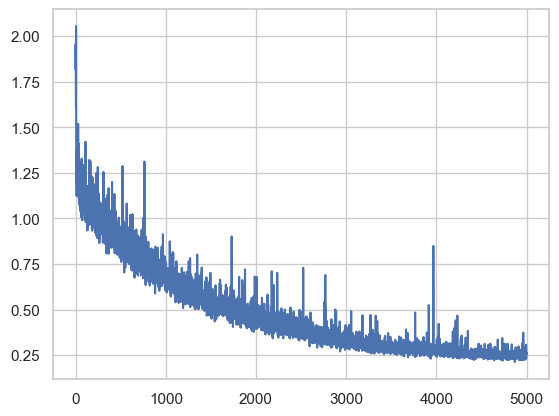

In [211]:
plt.plot(self.training_cost_list)

In [14]:
control_type = ["path_dependent", "markovian"][1]
input_param = (N * (control_type == "path_dependent") + 2)*d
input_param





# ============================================================================
# Define all parameters 
# ============================================================================
params = {
    # Parameters of the game setup
    "equation": {
            "state_dim": d, "BM_dim": d, "u_dim": d, 
            "M": 500, # number of particles
            "N": N,# number of time intervals
            "T": T,
            "control_type": control_type
        },
    "train": {
        "lr_actor": 1e-3, "gamma_actor":0.8, "milestones_actor": [30000, 40000],
        "iteration": 50, "epochs": 50, "device": device,  
    },
    "net": {
        # Choose block type: "res" for ResNet block, "fc" for fully connected block
        "block_type": ["fc", "rnn"][1],
        "inputs": input_param, "output": d, 


        # RNN network parameters(only used when block_type="rnn")
        "width": 100, "depth": 4, #N + 10, "depth": 4, 
        "activation": "ReLU", "penalty": "Tanh",
        "params_act": {"Tanh": nn.Tanh(), "Tanhshrink": nn.Tanhshrink(), "ReLU": nn.ReLU(), "ReLU6": nn.ReLU6()},
        
        
        # Fully connected network parameters (only used when block_type="fc")
        "hidden_layers": [20, 20], #[N + 10, N + 10, N + 10],  #widths of hidden layers 
        "dropout_rate": 0.1,  # Add dropout for regularization
    },
}


# ============================================================================
# Create control networks
# ============================================================================
net_control = Network(params["net"]) 


device = "cpu"
# setup = MeanVariance(params["equation"], device)

self2 = deepMKV(net_control, setup, params)
print(self2.control_type+ "_" +params["net"]["block_type"])
# t, W, DW = self.fetch_minibatch()

# X0 = setup.generate_initial_condition()
# X_buffer, loss = self2.loss_function( net_control, t, DW, X0)
# X_buffer, loss, net_actor =self2.simulation_paths()

self2.train_players()

dt 0.01
markovian_rnn


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


It: 0, loss_training: 1.0005, loss_validation: 0.9387
Updated learning rate: 0.001


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


It: 1, loss_training: 1.1639, loss_validation: 0.8016
Updated learning rate: 0.001


100%|██████████| 50/50 [00:44<00:00,  1.14it/s]


It: 2, loss_training: 0.8717, loss_validation: 0.8078
Updated learning rate: 0.001


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


It: 3, loss_training: 0.9169, loss_validation: 0.7731
Updated learning rate: 0.001


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


It: 4, loss_training: 0.7082, loss_validation: 0.7947
Updated learning rate: 0.001


100%|██████████| 50/50 [00:41<00:00,  1.20it/s]


It: 5, loss_training: 0.7523, loss_validation: 0.8879
Updated learning rate: 0.001


100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


It: 6, loss_training: 0.8368, loss_validation: 0.6327
Updated learning rate: 0.001


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


It: 7, loss_training: 1.1405, loss_validation: 0.6225
Updated learning rate: 0.001


100%|██████████| 50/50 [00:39<00:00,  1.26it/s]


It: 8, loss_training: 0.6537, loss_validation: 0.8722
Updated learning rate: 0.001


100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


It: 9, loss_training: 0.9086, loss_validation: 0.6497
Updated learning rate: 0.001


100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


It: 10, loss_training: 0.6120, loss_validation: 1.4106
Updated learning rate: 0.001


100%|██████████| 50/50 [00:40<00:00,  1.24it/s]


It: 11, loss_training: 0.5393, loss_validation: 1.0882
Updated learning rate: 0.001


100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


It: 12, loss_training: 0.6981, loss_validation: 0.6954
Updated learning rate: 0.001


100%|██████████| 50/50 [00:37<00:00,  1.33it/s]


It: 13, loss_training: 0.6079, loss_validation: 1.0094
Updated learning rate: 0.001


100%|██████████| 50/50 [00:37<00:00,  1.35it/s]


It: 14, loss_training: 0.6308, loss_validation: 0.5242
Updated learning rate: 0.001


100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


It: 15, loss_training: 0.7948, loss_validation: 0.5609
Updated learning rate: 0.001


100%|██████████| 50/50 [00:36<00:00,  1.37it/s]


It: 16, loss_training: 0.5103, loss_validation: 0.5900
Updated learning rate: 0.001


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


It: 17, loss_training: 0.5449, loss_validation: 0.5020
Updated learning rate: 0.001


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


It: 18, loss_training: 0.6197, loss_validation: 0.8399
Updated learning rate: 0.001


100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


It: 19, loss_training: 0.5292, loss_validation: 0.7553
Updated learning rate: 0.001


100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


It: 20, loss_training: 0.5582, loss_validation: 0.5804
Updated learning rate: 0.001


100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


It: 21, loss_training: 0.4817, loss_validation: 0.5819
Updated learning rate: 0.001


100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


It: 22, loss_training: 0.4198, loss_validation: 0.5258
Updated learning rate: 0.001


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


It: 23, loss_training: 1.1128, loss_validation: 0.5884
Updated learning rate: 0.001


100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


It: 24, loss_training: 2.4959, loss_validation: 0.9296
Updated learning rate: 0.001


100%|██████████| 50/50 [00:39<00:00,  1.26it/s]


It: 25, loss_training: 0.6396, loss_validation: 0.5758
Updated learning rate: 0.001


100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


It: 26, loss_training: 0.4425, loss_validation: 0.5873
Updated learning rate: 0.001


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


It: 27, loss_training: 0.5408, loss_validation: 4.1824
Updated learning rate: 0.001


100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


It: 28, loss_training: 0.3988, loss_validation: 0.5509
Updated learning rate: 0.001


100%|██████████| 50/50 [00:44<00:00,  1.14it/s]


It: 29, loss_training: 0.4296, loss_validation: 0.6135
Updated learning rate: 0.001


100%|██████████| 50/50 [00:41<00:00,  1.20it/s]


It: 30, loss_training: 0.3977, loss_validation: 0.4711
Updated learning rate: 0.001


100%|██████████| 50/50 [00:41<00:00,  1.20it/s]


It: 31, loss_training: 0.3976, loss_validation: 0.5801
Updated learning rate: 0.001


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


It: 32, loss_training: 0.4304, loss_validation: 0.5172
Updated learning rate: 0.001


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


It: 33, loss_training: 0.4375, loss_validation: 0.4770
Updated learning rate: 0.001


100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


It: 34, loss_training: 0.3621, loss_validation: 0.4895
Updated learning rate: 0.001


100%|██████████| 50/50 [00:40<00:00,  1.22it/s]


It: 35, loss_training: 0.4597, loss_validation: 0.3797
Updated learning rate: 0.001


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


It: 36, loss_training: 0.3810, loss_validation: 0.4665
Updated learning rate: 0.001


100%|██████████| 50/50 [00:38<00:00,  1.28it/s]


It: 37, loss_training: 0.5100, loss_validation: 0.4184
Updated learning rate: 0.001


100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


It: 38, loss_training: 0.3612, loss_validation: 0.3798
Updated learning rate: 0.001


100%|██████████| 50/50 [00:39<00:00,  1.25it/s]


It: 39, loss_training: 0.3836, loss_validation: 0.4421
Updated learning rate: 0.001


100%|██████████| 50/50 [00:37<00:00,  1.32it/s]


It: 40, loss_training: 0.4306, loss_validation: 0.5688
Updated learning rate: 0.001


100%|██████████| 50/50 [00:40<00:00,  1.22it/s]


It: 41, loss_training: 0.3701, loss_validation: 0.4094
Updated learning rate: 0.001


100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


It: 42, loss_training: 0.4258, loss_validation: 0.4240
Updated learning rate: 0.001


100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


It: 43, loss_training: 0.3614, loss_validation: 0.4813
Updated learning rate: 0.001


100%|██████████| 50/50 [00:41<00:00,  1.20it/s]


It: 44, loss_training: 0.5686, loss_validation: 0.3760
Updated learning rate: 0.001


100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


It: 45, loss_training: 0.3726, loss_validation: 0.3569
Updated learning rate: 0.001


100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


It: 46, loss_training: 0.4598, loss_validation: 0.3638
Updated learning rate: 0.001


100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


It: 47, loss_training: 0.5918, loss_validation: 0.4870
Updated learning rate: 0.001


100%|██████████| 50/50 [00:42<00:00,  1.19it/s]


It: 48, loss_training: 0.3450, loss_validation: 0.3846
Updated learning rate: 0.001


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


It: 49, loss_training: 0.3485, loss_validation: 0.4760
Updated learning rate: 0.001


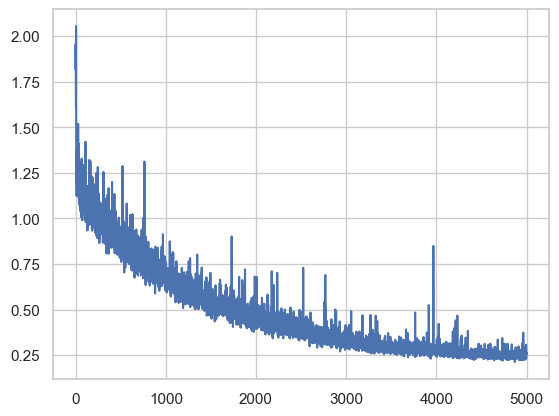

In [217]:
plt.plot(self.training_cost_list)

In [218]:
self.filename


'path_dependent_BM'

In [219]:
self.save_loss()

The loss data is saved in
outputLoss/path_dependent_BM_val_loss.csv


In [140]:
self2.train_players()

100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


It: 0, loss_training: 0.7571, loss_validation: 0.4568
Updated learning rate: 0.001


100%|██████████| 50/50 [00:34<00:00,  1.46it/s]


It: 1, loss_training: 0.3247, loss_validation: 0.3771
Updated learning rate: 0.001


100%|██████████| 50/50 [00:36<00:00,  1.35it/s]


It: 2, loss_training: 0.4450, loss_validation: 0.3583
Updated learning rate: 0.001


100%|██████████| 50/50 [00:34<00:00,  1.47it/s]


It: 3, loss_training: 0.3288, loss_validation: 0.3470
Updated learning rate: 0.001


100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


It: 4, loss_training: 0.3340, loss_validation: 1.0257
Updated learning rate: 0.001


100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


It: 5, loss_training: 0.3543, loss_validation: 0.3852
Updated learning rate: 0.001


100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


It: 6, loss_training: 0.3199, loss_validation: 0.3061
Updated learning rate: 0.001


100%|██████████| 50/50 [00:34<00:00,  1.47it/s]


It: 7, loss_training: 0.3256, loss_validation: 0.3460
Updated learning rate: 0.001


100%|██████████| 50/50 [00:34<00:00,  1.47it/s]


It: 8, loss_training: 0.3223, loss_validation: 0.3245
Updated learning rate: 0.001


100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


It: 9, loss_training: 0.3295, loss_validation: 0.3166
Updated learning rate: 0.001


100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


It: 10, loss_training: 0.3541, loss_validation: 0.3650
Updated learning rate: 0.001


100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


It: 11, loss_training: 0.4294, loss_validation: 0.5637
Updated learning rate: 0.001


100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


It: 12, loss_training: 0.3156, loss_validation: 0.3078
Updated learning rate: 0.001


100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


It: 13, loss_training: 0.3271, loss_validation: 0.3234
Updated learning rate: 0.001


100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


It: 14, loss_training: 0.3095, loss_validation: 0.3683
Updated learning rate: 0.001


100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


It: 15, loss_training: 0.2992, loss_validation: 0.3205
Updated learning rate: 0.001


100%|██████████| 50/50 [00:32<00:00,  1.52it/s]


It: 16, loss_training: 0.3019, loss_validation: 0.3585
Updated learning rate: 0.001


100%|██████████| 50/50 [00:32<00:00,  1.52it/s]


It: 17, loss_training: 0.3115, loss_validation: 0.3915
Updated learning rate: 0.001


100%|██████████| 50/50 [00:33<00:00,  1.51it/s]


It: 18, loss_training: 0.3011, loss_validation: 0.3077
Updated learning rate: 0.001


100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


It: 19, loss_training: 0.3005, loss_validation: 0.3024
Updated learning rate: 0.001


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


It: 20, loss_training: 0.3172, loss_validation: 0.3331
Updated learning rate: 0.001


100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


It: 21, loss_training: 0.2738, loss_validation: 0.3253
Updated learning rate: 0.001


100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


It: 22, loss_training: 0.2861, loss_validation: 0.3063
Updated learning rate: 0.001


100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


It: 23, loss_training: 0.2770, loss_validation: 0.3785
Updated learning rate: 0.001


100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


It: 24, loss_training: 0.2781, loss_validation: 0.2994
Updated learning rate: 0.001


100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


It: 25, loss_training: 0.2834, loss_validation: 0.2943
Updated learning rate: 0.001


100%|██████████| 50/50 [00:32<00:00,  1.56it/s]


It: 26, loss_training: 0.2904, loss_validation: 0.2830
Updated learning rate: 0.001


100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


It: 27, loss_training: 0.3014, loss_validation: 0.3171
Updated learning rate: 0.001


100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


It: 28, loss_training: 0.2712, loss_validation: 0.2754
Updated learning rate: 0.001


100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


It: 29, loss_training: 0.2921, loss_validation: 0.3335
Updated learning rate: 0.001


100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


It: 30, loss_training: 0.2807, loss_validation: 0.2722
Updated learning rate: 0.001


100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


It: 31, loss_training: 0.2771, loss_validation: 0.2927
Updated learning rate: 0.001


100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


It: 32, loss_training: 0.2647, loss_validation: 0.2809
Updated learning rate: 0.001


100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


It: 33, loss_training: 0.2711, loss_validation: 0.3187
Updated learning rate: 0.001


100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


It: 34, loss_training: 0.2821, loss_validation: 0.2890
Updated learning rate: 0.001


100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


It: 35, loss_training: 0.2796, loss_validation: 0.2804
Updated learning rate: 0.001


100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


It: 36, loss_training: 0.2792, loss_validation: 0.2892
Updated learning rate: 0.001


100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


It: 37, loss_training: 0.2669, loss_validation: 0.3103
Updated learning rate: 0.001


100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


It: 38, loss_training: 0.2701, loss_validation: 0.2808
Updated learning rate: 0.001


100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


It: 39, loss_training: 0.2578, loss_validation: 0.2986
Updated learning rate: 0.001


100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


It: 40, loss_training: 0.2733, loss_validation: 0.2681
Updated learning rate: 0.001


100%|██████████| 50/50 [00:32<00:00,  1.52it/s]


It: 41, loss_training: 0.3173, loss_validation: 0.2989
Updated learning rate: 0.001


100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


It: 42, loss_training: 0.2678, loss_validation: 0.2609
Updated learning rate: 0.001


100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


It: 43, loss_training: 0.2698, loss_validation: 0.2583
Updated learning rate: 0.001


100%|██████████| 50/50 [00:39<00:00,  1.27it/s]


It: 44, loss_training: 0.3110, loss_validation: 0.2829
Updated learning rate: 0.001


100%|██████████| 50/50 [00:33<00:00,  1.51it/s]


It: 45, loss_training: 0.2600, loss_validation: 0.3564
Updated learning rate: 0.001


100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


It: 46, loss_training: 0.2674, loss_validation: 0.2728
Updated learning rate: 0.001


100%|██████████| 50/50 [00:32<00:00,  1.52it/s]


It: 47, loss_training: 0.2626, loss_validation: 0.2647
Updated learning rate: 0.001


100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


It: 48, loss_training: 0.2670, loss_validation: 0.2746
Updated learning rate: 0.001


100%|██████████| 50/50 [00:39<00:00,  1.27it/s]

It: 49, loss_training: 0.2575, loss_validation: 0.2519
Updated learning rate: 0.001


In [63]:
self.control_type = "path_dependent"
K = 1.25


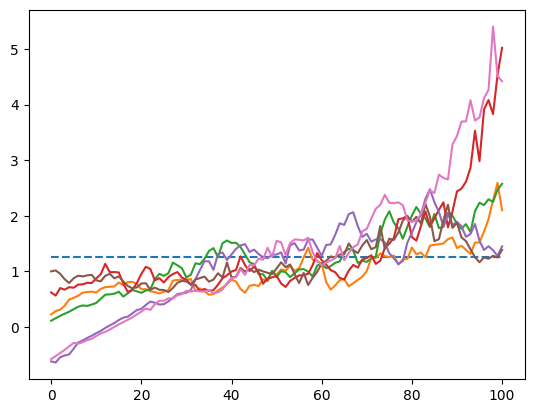

In [142]:
X_buffer1, loss, net_actor =self.simulation_paths()
len(X_buffer1)
plt.plot([K for i in range(len(X_buffer1))], "--")

plt.plot([X_buffer1[i][0,0].detach() for i in range(len(X_buffer1))])
plt.plot([X_buffer1[i][5,0].detach() for i in range(len(X_buffer1))])
plt.plot([X_buffer1[i][10,0].detach() for i in range(len(X_buffer1))])
plt.plot([X_buffer1[i][20,0].detach() for i in range(len(X_buffer1))])
plt.plot([X_buffer1[i][220,0].detach() for i in range(len(X_buffer1))])

plt.plot([X_buffer1[i][100,0].detach() for i in range(len(X_buffer1))])

In [143]:
X_path1 = torch.stack(X_buffer1, dim=1)  # [X0, X1, ..., XT]


payoff  =torch.abs(torch.mean(X_path1, dim=1) - K)
mean_payoff = torch.mean(payoff)
var_payoff = torch.var(payoff)
print(mean_payoff, var_payoff)
print(var_payoff + mean_payoff)

tensor(0.1323, grad_fn=<MeanBackward0>) tensor(0.0165, grad_fn=<VarBackward0>)
tensor(0.1489, grad_fn=<AddBackward0>)


In [144]:
self2.control_type

'markovian'

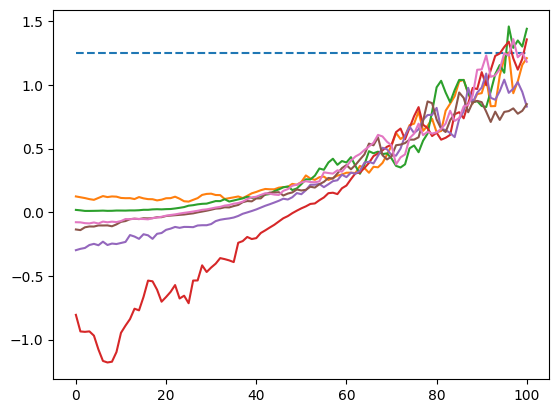

In [145]:
X_buffer, loss, net_actor =self2.simulation_paths()
len(X_buffer)
plt.plot([K for i in range(len(X_buffer1))], "--")
plt.plot([X_buffer[i][0,0].detach() for i in range(len(X_buffer1))])
plt.plot([X_buffer[i][5,0].detach() for i in range(len(X_buffer1))])
plt.plot([X_buffer[i][10,0].detach() for i in range(len(X_buffer1))])
plt.plot([X_buffer[i][20,0].detach() for i in range(len(X_buffer1))])
plt.plot([X_buffer[i][220,0].detach() for i in range(len(X_buffer1))])

plt.plot([X_buffer[i][100,0].detach() for i in range(len(X_buffer1))])

In [146]:
X_path = torch.stack(X_buffer, dim=1)  # [X0, X1, ..., XT]

K = 1.25
payoff  =torch.abs(torch.mean(X_path, dim=1) - K)
mean_payoff = torch.mean(payoff)
var_payoff = torch.var(payoff)
print(mean_payoff, var_payoff)
print(var_payoff + mean_payoff)

tensor(0.9085, grad_fn=<MeanBackward0>) tensor(0.0235, grad_fn=<VarBackward0>)
tensor(0.9320, grad_fn=<AddBackward0>)


In [19]:
PathModel.g_terminal(PathModel, X_path)

tensor(0.8982, grad_fn=<AddBackward0>)

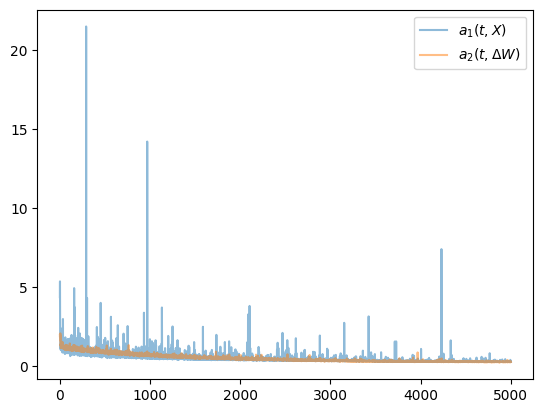

In [149]:
plt.plot(self2.training_cost_list[:],label=r"$a_1(t, X)$"  , alpha=0.5)
plt.plot(self.training_cost_list[:],label=r"$a_2(t, \Delta W)$", alpha=0.5)

# plt.ylim([0,5])
plt.legend()

In [80]:
np.shape(X_path)

torch.Size([500, 101, 1])

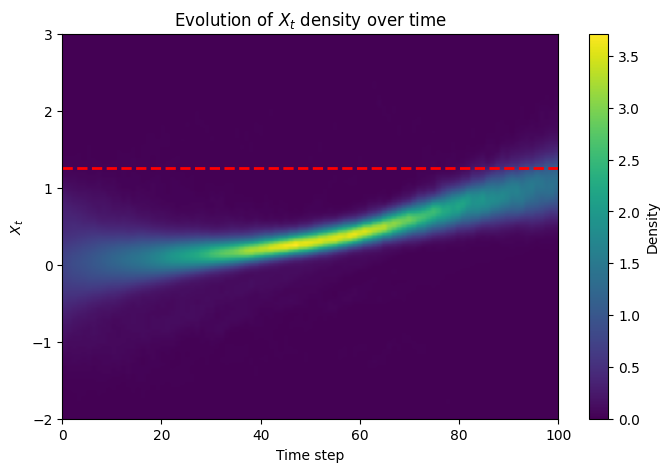

In [100]:
import numpy as np
from scipy.stats import gaussian_kde

X = X_path.detach().squeeze(-1).numpy()
times = np.arange(101)
x_grid = np.linspace(X.min(), X.max(), 200)

density_matrix = np.zeros((len(x_grid), len(times)))

for i, t in enumerate(times):
    kde = gaussian_kde(X[:, t])
    density_matrix[:, i] = kde(x_grid)

plt.figure(figsize=(8, 5))
plt.imshow(
    density_matrix,
    aspect='auto',
    origin='lower',
    extent=[0, 100, x_grid[0], x_grid[-1]],
    cmap='viridis'
)
# 加一条水平线 y=1.25
plt.axhline(y=1.25, color='red', linestyle='--', linewidth=2, label='Density = 1.25')

plt.colorbar(label='Density')
plt.xlabel('Time step')
plt.ylim([-2,3])
plt.ylabel(r'$X_t$')
plt.title('Evolution of $X_t$ density over time')
plt.show()

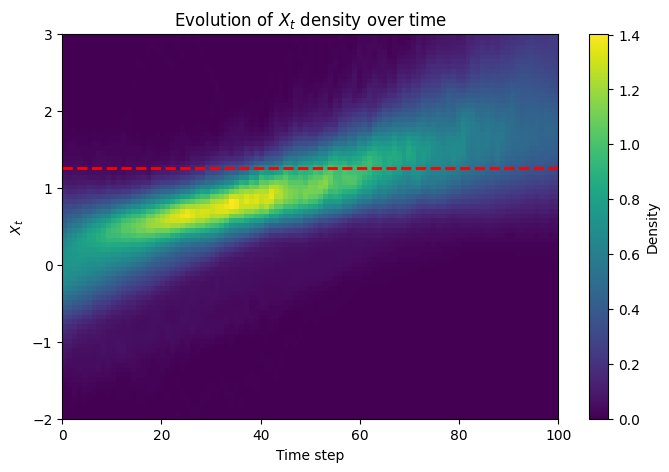

In [101]:
import numpy as np
from scipy.stats import gaussian_kde

X = X_path1.detach().squeeze(-1).numpy()
times = np.arange(101)
x_grid = np.linspace(X.min(), X.max(), 200)

density_matrix = np.zeros((len(x_grid), len(times)))

for i, t in enumerate(times):
    kde = gaussian_kde(X[:, t])
    density_matrix[:, i] = kde(x_grid)

plt.figure(figsize=(8, 5))
plt.imshow(
    density_matrix,
    aspect='auto',
    origin='lower',
    extent=[0, 100, x_grid[0], x_grid[-1]],
    cmap='viridis'
)
# 加一条水平线 y=1.25
plt.axhline(y=1.25, color='red', linestyle='--', linewidth=2, label='Density = 1.25')
plt.ylim([-2,3])

plt.colorbar(label='Density')
plt.xlabel('Time step')
plt.ylabel(r'$X_t$')
plt.title('Evolution of $X_t$ density over time')
plt.show()

(500, 101)

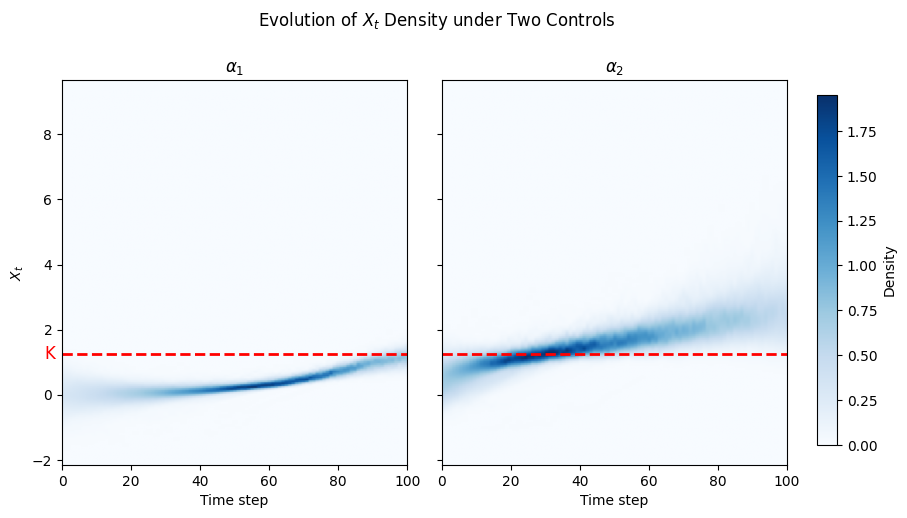

In [148]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Example data
X1 = X_path.detach().squeeze(-1).numpy()          # α₁
X2 = X_path1.detach().squeeze(-1).numpy() + 0.5    # α₂
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# 假设 X1, X2 已经定义
times = np.arange(101)
x_grid = np.linspace(min(X1.min(), X2.min()), max(X1.max(), X2.max()), 200)

def density_matrix(X):
    dens = np.zeros((len(x_grid), len(times)))
    for i, t in enumerate(times):
        kde = gaussian_kde(X[:, t])
        dens[:, i] = kde(x_grid)
    return dens

density1 = density_matrix(X1)
density2 = density_matrix(X2)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# α₁ heatmap
im1 = axes[0].imshow(density1, aspect='auto', origin='lower',
                     extent=[0, 100, x_grid[0], x_grid[-1]],
                     cmap='Blues')
axes[0].axhline(y=1.25, color='red', linestyle='--', linewidth=2)
axes[0].set_title(r"$\alpha_1$")
axes[0].set_xlabel("Time step")
axes[0].set_ylabel(r"$X_t$")

# α₂ heatmap
im2 = axes[1].imshow(density2, aspect='auto', origin='lower',
                     extent=[0, 100, x_grid[0], x_grid[-1]],
                     cmap='Blues')
axes[1].axhline(y=1.25, color='red', linestyle='--', linewidth=2)
axes[1].set_title(r"$\alpha_2$")
axes[1].set_xlabel("Time step")
axes[0].annotate(
    "K",
    xy=(0, 1.25),           # 对应数据坐标 (x=0, y=1.25)
    xytext=(-5, 0),        # 向左偏移（像素单位）
    textcoords='offset points',
    color='red',
    fontsize=12,
    va='center',
    ha='right'
)
# 调整布局，留出右侧空间
plt.subplots_adjust(right=0.85, wspace=0.1)

# 在右侧单独添加 colorbar
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label("Density")

plt.suptitle("Evolution of $X_t$ Density under Two Controls", y=1.02)
plt.show()


0.9084636 0.023441212
0.456942 0.028136337


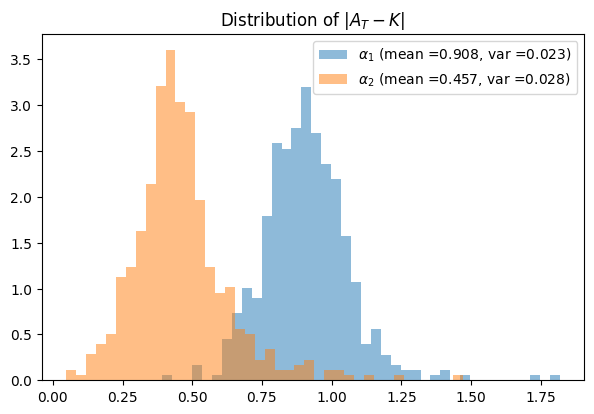

In [202]:
plt.style.use('default')

X1_minus_K = X1
AT_1 = np.abs(np.mean((X1), axis=1) - K)
plt.figure(figsize=(7,4.5))
mean1 = np.mean(AT_1)
var1 = np.var(AT_1)
print(mean1, var1)
plt.hist(AT_1, density=True, bins=40, alpha=0.5,   \
    label=r"$\alpha_1$" + " (mean =" + f"{mean1:.3f}" + ", var =" + f"{var1:.3f})")


X2_minus_K = X2
AT_2 = np.abs(np.mean((X2), axis=1) - K)
mean2 = np.mean(AT_2)
var2 = np.var(AT_2)
print(mean2, var2)

plt.hist(AT_2, density=True, bins=40, alpha=0.5, \
    label=r"$\alpha_2$" + " (mean =" + f"{mean2:.3f}" + ", var =" + f"{var2:.3f})")

plt.title("Distribution of " + r"$|A_T - K|$")
plt.legend()

plt.show()


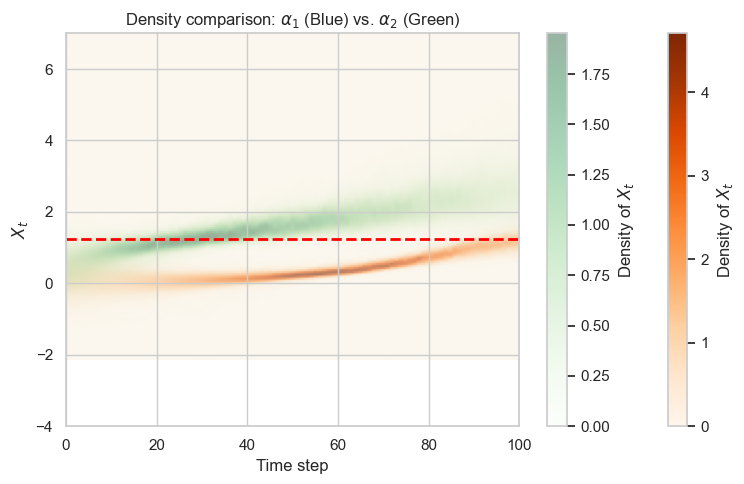

In [213]:
plt.figure(figsize=(8, 5))

plt.imshow(density1, aspect='auto', origin='lower',
           extent=[0, 100, x_grid[0], x_grid[-1]], cmap='Oranges', alpha=1)
plt.colorbar(label="Density of $X_t$")

plt.imshow(density2, aspect='auto', origin='lower',
           extent=[0, 100, x_grid[0], x_grid[-1]], cmap='Greens', alpha=0.4)
plt.axhline(y=1.25, color='red', linestyle='--', linewidth=2)

plt.xlabel("Time step")
plt.ylabel(r"$X_t$")
plt.ylim([-4,7])
plt.title(r"Density comparison: $\alpha_1$ (Blue) vs. $\alpha_2$ (Green)")
plt.colorbar(label="Density of $X_t$")
plt.tight_layout()
plt.show()


In [21]:
t, W, DW = self.fetch_minibatch()

In [22]:
import torch.nn.functional as F

def loss_function(
    self, net_actor, t, DW, X0):
    """
    Compute the loss for the critic and actor networks over a batch of trajectories.

    Inputs:
    - net_actor: neural net producing control
    - t: Tensor (M, N+1, 1), time grid for each sample path.
    - DW: Tensor (M, N, D), Brownian motion intervals.
    - X0: Tensor (M, state_dim), initial state for all the players.
    - control_type: str, either "path_dependent" or "markovian" 
    Returns:
    - loss_actor: scalar tensor of actor loss.
    - X: Tensor of simulated state trajectories (M, n+1, state_dim).
    """

    # Initialize loss and buffers
    
    # Require gradients for X0 for potential derivative computations
    Xt = X0
    Xt.requires_grad = True
    X0_block = X0.unsqueeze(1) 
    reward = 0
    X_buffer = [Xt]   # to store states (X) along path

    print("t shape", np.shape(t))
    # Loop over n time steps for this loss segment
    for j in range(0, self.N ):
       
        t_= t[:, j, :]
        DW_t = DW[:, j, :]
        t_block = t_.unsqueeze(1).expand(-1, 1, self.state_dim)  #  t0 -> (M, 1, d): duplicate the single column to state_dim

        X_path = torch.stack(X_buffer, dim=1)     # (M, j+1, d)

        hist_len = self.N + 1
        pad_len = hist_len - X_path.size(1)
        X_path_padded = F.pad(X_path, (0, 0, 0, pad_len), mode='constant', value=0.0) # [N+1, d]

        ## Generate the control based on control type
        if self.control_type == "path_dependent":
            #  control: depends on time, initial state, and Brownian path
            net_input = torch.cat([t_block,  X0_block, self.DW_mask(DW, j)], dim=1)   # (M, N+2, d)
            net_input = net_input.view(self.M,-1)
            control = net_actor(net_input) # batch * d
            
        elif self.control_type == "markovian":
            net_input =torch.cat([t_block,  X_path_padded], dim=1)       # (M, hist_len, d)
            net_input = net_input.view(self.M,-1)
            #print(np.shape(net_input))
            control = net_actor(net_input) 
            
        # get current reward
        #reward += self.setup.f_running(t_, X_path, control)* self.dt
        
        
        # Forward simulate SDE dynamics (Euler + jump terms)
        drift = self.setup.mu(t_, Xt, control)
        violatility = self.setup.sigma(t_, Xt, control)
        Xt = Xt + drift * self.dt + violatility * DW_t

        # Add Xt to the path history
        X_buffer.append(Xt)

    X_path_complete = torch.stack(X_buffer, dim=1)  # [X0, X1, ..., XT]
    print(np.shape(X_path_complete))
    # Calculate the terminal cost
    #reward += self.setup.g_terminal(X_path_complete) 
    return X_buffer, reward, X_path_complete

In [23]:
net_control

Network(
  (first): Linear(in_features=2, out_features=100, bias=True)
  (last): Linear(in_features=100, out_features=1, bias=True)
  (network): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): RNNBlock(
      (L1): Linear(in_features=100, out_features=100, bias=True)
      (L2): Linear(in_features=100, out_features=100, bias=True)
      (act): ReLU()
    )
    (2): RNNBlock(
      (L1): Linear(in_features=100, out_features=100, bias=True)
      (L2): Linear(in_features=100, out_features=100, bias=True)
      (act): ReLU()
    )
    (3): RNNBlock(
      (L1): Linear(in_features=100, out_features=100, bias=True)
      (L2): Linear(in_features=100, out_features=100, bias=True)
      (act): ReLU()
    )
    (4): RNNBlock(
      (L1): Linear(in_features=100, out_features=100, bias=True)
      (L2): Linear(in_features=100, out_features=100, bias=True)
      (act): ReLU()
    )
    (5): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [24]:
# self.control_type = "markovian"
# _, _, X_path_complete = loss_function(
#     self, net_control, t, DW, X0)

t shape torch.Size([500, 101, 1])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (500x102 and 2x100)

In [ ]:
t, W, DW =self.fetch_minibatch()

In [ ]:
np.shape(DW)

In [ ]:
STOP

In [ ]:
plt.plot(self.training_cost_list)
# df = pd.read_csv("outputLoss/path_dependent_rnn_val_loss.csv")
# plt.plot(df.values, alpha=0.5)

In [ ]:
# two_period_compare_affine.py
import numpy as np

# 参数
X0 = 1.0
R_vals = np.array([0.2, -0.2])   # up, down
p = np.array([0.5, 0.5])
lambda_risk = 3.0

def J_terminal(probs, X2_vals):
    EX = np.dot(probs, X2_vals)
    VarX = np.dot(probs, (X2_vals - EX)**2)
    return EX - 0.5 * lambda_risk * VarX

# 网格设置（较细以得到更稳健的结果）
pi0_grid = np.linspace(-1.0, 2.0, 121)
pi1_cond_grid = np.linspace(-1.5, 2.5, 61)  # 用于预承诺的条件决策网格
a_grid = np.linspace(-3.0, 3.0, 121)
b_grid = np.linspace(-2.0, 3.0, 121)

# Pre-commitment (open-loop adapted): choose pi0, pi1_up, pi1_down
best_pre = {'J': -1e9}
for pi0 in pi0_grid:
    X1_up = X0 + pi0 * R_vals[0]
    X1_dn = X0 + pi0 * R_vals[1]
    for pi1_u in pi1_cond_grid:
        for pi1_d in pi1_cond_grid:
            X2_up = X1_up + pi1_u * R_vals[0]
            X2_dn = X1_dn + pi1_d * R_vals[1]
            X2_vals = np.array([X2_up, X2_dn])
            Jval = J_terminal(p, X2_vals)
            if Jval > best_pre['J']:
                best_pre = {'J': Jval, 'pi0': pi0, 'pi1_u': pi1_u, 'pi1_d': pi1_d,
                            'X1_up': X1_up, 'X1_dn': X1_dn, 'X2_up': X2_up, 'X2_dn': X2_dn}

# Closed-loop affine: choose pi0 and (a,b) with pi1 = a * X1 + b
best_aff = {'J': -1e9}
for pi0 in pi0_grid:
    X1_up = X0 + pi0 * R_vals[0]
    X1_dn = X0 + pi0 * R_vals[1]
    for a in a_grid:
        for b in b_grid:
            pi1_up = a * X1_up + b
            pi1_dn = a * X1_dn + b
            X2_up = X1_up + pi1_up * R_vals[0]
            X2_dn = X1_dn + pi1_dn * R_vals[1]
            X2_vals = np.array([X2_up, X2_dn])
            Jval = J_terminal(p, X2_vals)
            if Jval > best_aff['J']:
                best_aff = {'J': Jval, 'pi0': pi0, 'a': a, 'b': b,
                            'X1_up': X1_up, 'X1_dn': X1_dn, 'X2_up': X2_up, 'X2_dn': X2_dn,
                            'pi1_up': pi1_up, 'pi1_dn': pi1_dn}

print("Best pre-commitment:", best_pre)
print("Best affine feedback:", best_aff)


In [215]:
# self2.save_NN(filename=self.control_type+ "_" +params["net"]["block_type"])
# self2.save_loss(filename=self.control_type+ "_" +params["net"]["block_type"])

The NN weights are saved in
outputNN/path_dependent_rnn.pth
The loss data is saved in
outputLoss/path_dependent_rnn_val_loss.csv


In [ ]:
# pd_policy_train.py
import torch, torch.nn as nn, torch.optim as optim
import numpy as np
import math, time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model & problem params
sigma = 1.0; kappa = 0.6; q = 0.8; T = 0.2; c = 2.0; eta = 2.0
N = 20; dt = T / N

class PathDependentPolicy(nn.Module):
    def __init__(self, N, hidden=64):
        super().__init__()
        # simple causal RNN: we feed dW increment at each step and produce alpha_t
        self.rnn = nn.GRU(input_size=1, hidden_size=hidden, batch_first=True)
        self.head = nn.Linear(hidden, 1)
    def forward(self, dWs): # dWs: (batch, N) realisations multiplied by sqrt(dt)
        # expand to (batch, N, 1)
        x = dWs.unsqueeze(-1)
        out, _ = self.rnn(x)           # (batch, N, hidden)
        a = self.head(out).squeeze(-1) # (batch, N) alpha at each step, causal
        return a

# simulate SDE under policy (vectorized, differentiable)
def simulate_policy(policy, M, seed=0):
    torch.manual_seed(seed)
    dWs = torch.randn(M, N, device=device) * math.sqrt(dt)  # (M, N)
    X = torch.randn(M, device=device) * 0.2
    running_cost = torch.zeros(M, device=device)
    a_seq = policy(dWs)  # (M, N)
    for n in range(N):
        meanX = X.mean(dim=0)
        a = a_seq[:, n]
        running_cost += (0.5 * a**2 - q * a * (meanX - X) + 0.5 * eta * (meanX - X)**2) * dt
        X = X + (kappa * (meanX - X) + a) * dt + sigma * dWs[:, n]
    meanX = X.mean(dim=0)
    terminal_cost = 0.5 * c * (X - meanX)**2
    total = running_cost + terminal_cost
    return total.mean()

# training loop
policy = PathDependentPolicy(N, hidden=128).to(device)
optimiser = optim.Adam(policy.parameters(), lr=1e-3)
epochs = 1000
batch_size = 2000

for ep in range(epochs):
    optimiser.zero_grad()
    loss = simulate_policy(policy, M=batch_size, seed=ep)
    loss.backward()
    optimiser.step()
    if ep % 50 == 0:
        print(f"ep {ep} loss {loss.item():.6f}")

# final evaluations vs markovian baseline
def eval_feedback(k, M=5000, seed=1234):
    torch.manual_seed(seed)
    X = torch.randn(M, device=device) * 0.2
    running = torch.zeros(M, device=device)
    for n in range(N):
        meanX = X.mean(dim=0)
        a = -k * (X - meanX)
        running += (0.5 * a**2 - q * a * (meanX - X) + 0.5 * eta * (meanX - X)**2) * dt
        dW = torch.randn(M, device=device) * math.sqrt(dt)
        X = X + (kappa * (meanX - X) + a) * dt + sigma * dW
    meanX = X.mean(dim=0)
    total = running + 0.5 * c * (X - meanX)**2
    return total.mean().item()

pd_cost = simulate_policy(policy, M=5000, seed=9999).item()
fb_cost = eval_feedback(q, M=5000, seed=9999)
print("Final costs (pd policy, feedback):", pd_cost, fb_cost)


In [ ]:
# More efficient Monte Carlo with precomputed Brownian increments and coarser grids.
import numpy as np
from math import ceil

# Parameters
X0 = 1.0
mu = 0.2
sigma = 0.5
T = 1.0
dt = 0.01
n_steps = int(T/dt)
tau = 0.5
tau_step = int(tau/dt)
M = 4000  # number of paths
lam = 3.0

rng = np.random.default_rng(12345)
dW_all = rng.normal(0.0, np.sqrt(dt), size=(M, n_steps))

def compute_X_for_open(pi0, pi1_up, pi1_dn):
    X = np.full(M, X0)
    # up to tau
    for i in range(tau_step):
        dW = dW_all[:, i]
        X += pi0 * mu * dt + pi0 * sigma * dW
    up_mask = (X - X0) > 0
    # remaining steps
    for i in range(tau_step, n_steps):
        dW = dW_all[:, i]
        pis = np.where(up_mask, pi1_up, pi1_dn)
        X += pis * mu * dt + pis * sigma * dW
    return X

def compute_X_for_affine(pi0, a, b):
    X = np.full(M, X0)
    for i in range(tau_step):
        dW = dW_all[:, i]
        X += pi0 * mu * dt + pi0 * sigma * dW
    for i in range(tau_step, n_steps):
        dW = dW_all[:, i]
        pis = a * X + b
        X += pis * mu * dt + pis * sigma * dW
    return X

def J_from_samples(Xs):
    EX = np.mean(Xs)
    VarX = np.var(Xs, ddof=0)
    return EX - 0.5 * lam * VarX

# Coarse grids
pi0_grid = np.linspace(-0.8, 1.2, 17)
pi1_grid = np.linspace(-2.0, 2.0, 25)
a_grid = np.linspace(-3.0, 3.0, 25)
b_grid = np.linspace(-1.5, 2.0, 25)

best_open = {'J': -1e9}
# iterate pi0 outer for reuse? we'll loop all
for pi0 in pi0_grid:
    # compute X at tau once for this pi0 to speed up evaluation across pi1 pairs
    X_tau = np.full(M, X0)
    for i in range(tau_step):
        dW = dW_all[:, i]
        X_tau += pi0 * mu * dt + pi0 * sigma * dW
    up_mask = (X_tau - X0) > 0
    # Now for each pair of pi1 values, simulate remainder quickly by accumulating deterministic + stochastic increments
    # Precompute sum of dW over remaining steps and per-path sum weighted? but pis vary per path so loop over grid
    for pi1_up in pi1_grid:
        for pi1_dn in pi1_grid:
            X = X_tau.copy()
            for i in range(tau_step, n_steps):
                dW = dW_all[:, i]
                pis = np.where(up_mask, pi1_up, pi1_dn)
                X += pis * mu * dt + pis * sigma * dW
            Jval = J_from_samples(X)
            if Jval > best_open['J']:
                best_open.update({'J': Jval, 'pi0': pi0, 'pi1_up': pi1_up, 'pi1_dn': pi1_dn})

best_aff = {'J': -1e9}
for pi0 in pi0_grid:
    # compute X up to tau
    X = np.full(M, X0)
    for i in range(tau_step):
        dW = dW_all[:, i]
        X += pi0 * mu * dt + pi0 * sigma * dW
    # now search over a,b
    for a in a_grid:
        for b in b_grid:
            Xc = X.copy()
            for i in range(tau_step, n_steps):
                dW = dW_all[:, i]
                pis = a * Xc + b
                Xc += pis * mu * dt + pis * sigma * dW
            Jval = J_from_samples(Xc)
            if Jval > best_aff['J']:
                best_aff.update({'J': Jval, 'pi0': pi0, 'a': a, 'b': b})

best_open, best_aff

